# Pacotes

In [ ]:
! pip install plotly==4.9.0 #bibliotecas necessárias
! pip install -U kaleido
! pip install psutil
! pip install orca #exporta os gráficos, no colab atualmente isso modificou para novos programas, nesse na época instalei assim e até hoje roda.
! pip install chart-studio==1.0.0
! pip install Pillow
! pip install DateTime
! pip install seaborn
!pip install gspread
!pip install gspread-dataframe

In [ ]:
caminho = '/content/drive/My Drive/Estudos/Faculdade/LABIMEC/COVID19/Post_ig' #caminho para salvar as imagens

In [ ]:
import numpy as np #bibliotecas utilizadas 
import pandas as pd
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from pandas.tseries.offsets import BDay
from datetime import date,datetime, timedelta
from PIL import Image 
import seaborn as sns; sns.set()
import plotly.figure_factory as ff
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials
from gspread_dataframe import get_as_dataframe, set_with_dataframe
import os	
import requests, zipfile, io
from os import chdir, getcwd, listdir
import shutil

In [ ]:
inicio_analise = (date.today()-timedelta(7)).strftime('%Y-%m-%d')
final_analise = (date.today()-timedelta(1)).strftime('%Y-%m-%d')
inicio_passada = (date.today()-timedelta(14)).strftime('%Y-%m-%d')
final_passada = inicio_analise

In [ ]:
 auth.authenticate_user() #cria condições por causa da dashboard
gc = gspread.authorize(GoogleCredentials.get_application_default())

#Banco de dados

In [ ]:
#bancodados de referencia, fonte: https://superset.plataformatarget.com.br/superset/dashboard/72/ e https://www.instagram.com/saudepbgov/
referencia = pd.read_excel('/content/drive/My Drive/Estudos/Faculdade/LABIMEC/COVID19/referencia.xlsx', index_col='data') #referencia
 
#banco de referencia, fonte: https://www.worldometers.info/coronavirus/
pbbrmd = pd.read_excel('/content/drive/My Drive/Estudos/Faculdade/LABIMEC/COVID19/brmd.xlsx', index_col='data') #Brasil e Mundo
 
#banco de referencia, fonte: https://superset.plataformatarget.com.br/superset/dashboard/72/ 
leitos_disponiveis = pd.read_excel('/content/drive/My Drive/Estudos/Faculdade/LABIMEC/COVID19/leitosdispmcp.xlsx', index_col='data') #Leitos disp. nos Municípios
 
#banco de referencia, fonte: https://www.instagram.com/saudepbgov/
leitos_adultos = pd.read_excel('/content/drive/My Drive/Estudos/Faculdade/LABIMEC/COVID19/leitosadultos.xlsx', index_col='data') #leitos adultos


In [ ]:
bancodados = {'Referencia': referencia,
              'PBBRMD': pbbrmd,
              'Leitos Disponíveis': leitos_disponiveis,  #ese dado modificou-s, em vez de por município virou por hospital
                                  #, foi descontinuado em 09/04/2021
              'Leitos Adultos': leitos_adultos} #dados disponíveis coletados

In [ ]:
leitos_por_hospital = pd.DataFrame()  #leitos disponíveis por hospital, série substitui a por municipios

#não foi possível agregar os hospitais por município para continuar a série pois há hospitais que possuem em mais de 1 cidade
#dessa forma, não consigo afirmar em com toda certeza a quantidade por município
#como não seria 100% confiável, essa informação não foi agregada.


chdir('/content/drive/MyDrive/Estudos/Faculdade/LABIMEC/COVID19/leitos_disp') #entra na pasta
for arquivo in listdir(): #le todos os arquivos da pasta
  data_do_dia = [] #armazena a coluna data que sera criada
  if arquivo[-4:] == '.csv': #lê apenas os csv's que existem na pasta
    aux = pd.read_csv('/content/drive/MyDrive/Estudos/Faculdade/LABIMEC/COVID19/leitos_disp/'+arquivo) #le o arquivo
    for i in list(range(len(aux))): #cria a coluna data do comprimento do n.º de hospitais
      data_do_dia.append((arquivo[:-4])) #exclui o csv q faz parte do nome e adiciona a data para criar a coluna
    aux.index = data_do_dia #adiciona a coluna 
    aux.columns = ['Unidade hospitalar', 'qnt_enf_unid_hosp','qnt_uti_unid_hosp'] #renomeia as colunas
    leitos_por_hospital = pd.concat([leitos_por_hospital,aux]) #junta os dados coletados
    
leitos_por_hospital.index = pd.to_datetime(leitos_por_hospital.index) #transforma em datatime a coluna do dia
leitos_por_hospital.index.name = 'data' #nomeia o indice como data, que é a coluna da data

In [ ]:
bancodados.update({'leitos disponíveis por hospital': leitos_por_hospital}) #adiciona ao dicionario da base de dados existente 

In [ ]:
for i in bancodados.keys(): #percorre todos os dados e 
  print(bancodados[i].describe().to_latex()) #printa no formato latex, para utilizar no overleaf

\begin{tabular}{lrrrrrrr}
\toprule
{} &    confirmados &       obitos &    recuperados &     qnt\_enf &     qnt\_uti &    ocup\_enf &    ocup\_uti \\
\midrule
count &     586.000000 &   586.000000 &     586.000000 &  586.000000 &  586.000000 &  586.000000 &  586.000000 \\
mean  &  244236.435154 &  5307.066553 &  176201.597270 &  577.735495 &  390.017065 &    0.362423 &    0.468430 \\
std   &  149256.253649 &  3136.667727 &  112179.082276 &   99.662147 &  117.074305 &    0.182009 &    0.194814 \\
min   &    2030.000000 &   114.000000 &     490.000000 &  454.000000 &  204.000000 &    0.100000 &    0.160000 \\
25\%   &  121925.000000 &  2836.750000 &   96895.750000 &  494.000000 &  300.000000 &    0.240000 &    0.310000 \\
50\%   &  216324.000000 &  4426.000000 &  157457.500000 &  556.000000 &  339.000000 &    0.340000 &    0.490000 \\
75\%   &  414841.250000 &  8903.250000 &  287469.000000 &  668.250000 &  536.250000 &    0.490000 &    0.620000 \\
max   &  462585.000000 &  9559.000000 & 

## Tabelas

## N.º de Ativos, hospitalizados e sua distribuição

In [ ]:
tabela1 = pd.DataFrame() #ativos, hospitalizados, pacientes na uti e enfermaria
tabela1['ativos'] = (bancodados['Referencia']['confirmados']- bancodados['Referencia']['obitos']-bancodados['Referencia']['recuperados'])
tabela1['hospitalizados na uti']= bancodados['Referencia']['qnt_uti']*bancodados['Referencia']['ocup_uti']
tabela1['hospitalizados na enf'] = bancodados['Referencia']['qnt_enf']*bancodados['Referencia']['ocup_enf']
tabela1['hospitalizados'] = (tabela1['hospitalizados na uti']+tabela1['hospitalizados na enf'])
tabela1 = round(tabela1,0)
tabela1.iloc[-20:].to_excel('/content/ultimos_20_dias.xlsx') #principais dados
print('Período coletado',tabela1.index[0].strftime('%d/%m/%y'),'a',tabela1.index[-1].strftime('%d/%m/%y')) #período de coleta
tabela1.iloc[-7:] #infos da última semana 

Período coletado 08/05/20 a 14/12/21


,ativos,hospitalizados na uti,hospitalizados na enf,hospitalizados
data,,,,
2021-12-08,95449,57.0,45.0,102.0
2021-12-09,95459,57.0,45.0,102.0
2021-12-10,95483,57.0,45.0,102.0
2021-12-11,95488,57.0,45.0,102.0
2021-12-12,95488,57.0,45.0,103.0
2021-12-13,95488,57.0,45.0,103.0
2021-12-14,95488,57.0,45.0,103.0


## Taxa de casos graves hospitalizados

In [ ]:
txagraveshosp = pd.DataFrame((tabela1['hospitalizados na uti']/tabela1['hospitalizados'])*100, columns=['Pacientes Graves Hospitalizados'])
#taxa de casos graves = (hospitalziados na uti / hospitalizados)*100 (%)
txagraveshosp.iloc[-7:] #evolução da taxa de casos graves em relação aos hospitalizados da última semana

,Pacientes Graves Hospitalizados
data,
2021-12-08,55.882353
2021-12-09,55.882353
2021-12-10,55.882353
2021-12-11,55.882353
2021-12-12,55.339806
2021-12-13,55.339806
2021-12-14,55.339806


## Variação do n.º de pacientes e de sua distribuição

In [ ]:
saldo1 = tabela1.diff().copy() #variação da última semana dos dados de referência
#variação = dia atual - dia anterior
saldo1.iloc[-7:]

,ativos,hospitalizados na uti,hospitalizados na enf,hospitalizados
data,,,,
2021-12-08,-351.0,0.0,0.0,0.0
2021-12-09,10.0,0.0,0.0,0.0
2021-12-10,24.0,0.0,0.0,0.0
2021-12-11,5.0,0.0,0.0,0.0
2021-12-12,0.0,0.0,0.0,1.0
2021-12-13,0.0,0.0,0.0,0.0
2021-12-14,0.0,0.0,0.0,0.0


## Taxa de casos graves em relação aos ativos (BR, PB e Mundo)

In [ ]:
tabela2 = pd.DataFrame() 

#taxas de casos graves em relação aos ativos = hospitalizados na uti / casos ativos
#ou ainda taxas se usa casos graves / casos ativos. 
        #na PB não temos com exatidão o n.º de casos graves. Assumimos que todo caso grave está na UTI, já que o sistema nunca colapsou
        #já as enfermarias representam casos leves.
        
tabela2['Paraíba'] = (tabela1['hospitalizados na uti']/tabela1['ativos'])*100
tabela2['Brasil'] = (bancodados['PBBRMD']['brgraves'])/(bancodados['PBBRMD']['brativos'])*100
tabela2['Mundo'] = (bancodados['PBBRMD']['mdgraves'])/(bancodados['PBBRMD']['mdativos'])*100
tabela2.iloc[-7:] #variação entre br, mundo e PB da última semana

,Paraíba,Brasil,Mundo
data,,,
2021-12-08,0.059718,4.855242,0.411910
2021-12-09,0.059711,4.855242,0.411910
2021-12-10,0.059696,4.855242,0.411910
2021-12-11,0.059693,5.244376,0.401575
2021-12-12,0.059693,5.177683,0.402436
2021-12-13,0.059693,5.061581,0.403442
2021-12-14,0.059693,NaN,NaN


In [ ]:
tabela2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 586 entries, 2020-05-08 to 2021-12-14
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Paraíba  586 non-null    float64
 1   Brasil   585 non-null    float64
 2   Mundo    585 non-null    float64
dtypes: float64(3)
memory usage: 18.3 KB


## N.ºde leitos disponíveis

In [ ]:
uti_disp = bancodados['Referencia']['qnt_uti']-tabela1['hospitalizados na uti'] 
enf_disp = bancodados['Referencia']['qnt_enf']-tabela1['hospitalizados na enf']
leitos_disponiveis = pd.DataFrame()
leitos_disponiveis['UTI'] = uti_disp
leitos_disponiveis['Enfermaria'] = enf_disp
leitos_disponiveis.iloc[-7:] # evolução da última semana dos leitos disponiveis  na Paraíba

,UTI,Enfermaria
data,,
2021-12-08,243.0,409.0
2021-12-09,243.0,409.0
2021-12-10,243.0,409.0
2021-12-11,243.0,409.0
2021-12-12,244.0,409.0
2021-12-13,244.0,409.0
2021-12-14,244.0,409.0


In [ ]:
leitos_disponiveis.diff().iloc[-7:] #variação da última semana
#variação = leito disponível hoje - leito disponível ontem

,UTI,Enfermaria
data,,
2021-12-08,0.0,0.0
2021-12-09,0.0,0.0
2021-12-10,0.0,0.0
2021-12-11,0.0,0.0
2021-12-12,1.0,0.0
2021-12-13,0.0,0.0
2021-12-14,0.0,0.0


### Representatividade dos leitos disponíveis - DESCONTINUADO

---



In [ ]:
rep_leitos_por_mun = pd.DataFrame()
#representatividade = leitos disponíveis no município / leitos totais disponíveis
    #essa informação foi importante para mostrar a concentração de leitos nas regiões metropolitanas e escassez no sertão da Paraíba
    #somente João Pessoa e Campina Grande possuiam juntas cerca de mais de 80% dos leitos dos estados, 
        #chegando alcançar quase 90% de representatividade juntas 

#UTIS - DESCONTINUADO, não excluído para preservar a história do código.

rep_leitos_por_mun['João Pessoa'] = (bancodados['Leitos Disponíveis']['jp_uti']/leitos_disponiveis['UTI'])*100
rep_leitos_por_mun['Campina Grande'] = (bancodados['Leitos Disponíveis']['uti_cg']/leitos_disponiveis['UTI'])*100
rep_leitos_por_mun['Cajazeiras'] = (bancodados['Leitos Disponíveis']['uti_caj']/leitos_disponiveis['UTI'])*100
rep_leitos_por_mun['Patos'] = (bancodados['Leitos Disponíveis']['Uti_patos']/leitos_disponiveis['UTI'])*100
rep_leitos_por_mun['Santa Rita'] = (bancodados['Leitos Disponíveis']['Uti_sr']/leitos_disponiveis['UTI'])*100
rep_leitos_por_mun['Pianco'] = (bancodados['Leitos Disponíveis']['Uti_pia']/leitos_disponiveis['UTI'])*100
rep_leitos_por_mun['Pombal'] = (bancodados['Leitos Disponíveis']['Uti_pom']/leitos_disponiveis['UTI'])*100
var_rep_utis = pd.DataFrame(rep_leitos_por_mun.loc[final_analise]-rep_leitos_por_mun.loc[inicio_analise], columns=['Variação da representatividade das UTIs da última semana (%)'])
#********************************************************************************************************************************************************************
#enfermarias disponíveis
rep_leitos_por_mun_enf = pd.DataFrame() #descontinuado pelo motivo acima
rep_leitos_por_mun_enf['João Pessoa'] = (bancodados['Leitos Disponíveis']['enfjp']/leitos_disponiveis['Enfermaria'])*100
rep_leitos_por_mun_enf['Campina Grande'] = (bancodados['Leitos Disponíveis']['enfcg']/leitos_disponiveis['Enfermaria'])*100
rep_leitos_por_mun_enf['Cajazeiras'] = (bancodados['Leitos Disponíveis']['enf_caj']/leitos_disponiveis['Enfermaria'])*100
rep_leitos_por_mun_enf['Patos'] = (bancodados['Leitos Disponíveis']['Enf_patos']/leitos_disponiveis['Enfermaria'])*100
rep_leitos_por_mun_enf['Santa Rita'] = (bancodados['Leitos Disponíveis']['Enf_sr']/leitos_disponiveis['Enfermaria'])*100
rep_leitos_por_mun_enf['Pianco'] = (bancodados['Leitos Disponíveis']['Enf_pia']/leitos_disponiveis['Enfermaria'])*100
rep_leitos_por_mun_enf['Pombal'] = (bancodados['Leitos Disponíveis']['Enf_pom']/leitos_disponiveis['Enfermaria'])*100
var_rep_enfs = pd.DataFrame((rep_leitos_por_mun_enf.loc[final_analise]-rep_leitos_por_mun_enf.loc[inicio_analise]), columns=['Variação da representatividade das Enf.s da última semana (%)'])


#********************************************************************************************************************************************************************
#leitos totais disponíveis
rep_leitos_por_mun_total = pd.DataFrame() #descontinuado pelo motivo acima
rep_leitos_por_mun_total['João Pessoa'] = (bancodados['Leitos Disponíveis']['enfjp']+bancodados['Leitos Disponíveis']['jp_uti'])/(leitos_disponiveis['Enfermaria']+leitos_disponiveis['UTI'])*100
rep_leitos_por_mun_total['Campina Grande'] = (bancodados['Leitos Disponíveis']['enfcg']+bancodados['Leitos Disponíveis']['uti_cg'])/(leitos_disponiveis['Enfermaria']+leitos_disponiveis['UTI'])*100
rep_leitos_por_mun_total['Cajazeiras'] = (bancodados['Leitos Disponíveis']['enf_caj']+bancodados['Leitos Disponíveis']['uti_caj'])/(leitos_disponiveis['Enfermaria']+leitos_disponiveis['UTI'])*100
rep_leitos_por_mun_total['Patos'] = (bancodados['Leitos Disponíveis']['Enf_patos']+bancodados['Leitos Disponíveis']['Uti_patos'])/(leitos_disponiveis['Enfermaria']+leitos_disponiveis['UTI'])*100
rep_leitos_por_mun_total['Santa Rita'] = (bancodados['Leitos Disponíveis']['Enf_sr']+bancodados['Leitos Disponíveis']['Uti_sr'])/(leitos_disponiveis['Enfermaria']+leitos_disponiveis['UTI'])*100
rep_leitos_por_mun_total['Pianco'] = (bancodados['Leitos Disponíveis']['Enf_pia']+bancodados['Leitos Disponíveis']['Uti_pia'])/(leitos_disponiveis['Enfermaria']+leitos_disponiveis['UTI'])*100
rep_leitos_por_mun_total['Pombal'] = (bancodados['Leitos Disponíveis']['Enf_pom']+bancodados['Leitos Disponíveis']['Uti_pom'])/(leitos_disponiveis['Enfermaria']+leitos_disponiveis['UTI'])*100
var_rep_total = pd.DataFrame(rep_leitos_por_mun_total.loc[final_analise]-rep_leitos_por_mun_total.loc[inicio_analise], columns=['Variação (%) da representatividade dos leitos - Agregado'])


#********************************************************************************************************************************************************************
representacao_municipio = pd.DataFrame() #trazia a informação da variação semanal da representatividade das utis, 
#DESCONTINUADO
representacao_municipio['Inicio'] = rep_leitos_por_mun.loc[inicio_analise]
representacao_municipio['Final'] = rep_leitos_por_mun.loc[final_analise]
representacao_municipio['Variação'] = representacao_municipio['Final']-representacao_municipio['Inicio']

In [ ]:
comparativo_d30 = ((tabela1/tabela1.shift(30))-1).ewm(span=13, adjust=False).mean()
#comparação em relação há 30 dias = informação hoje / informação de 30 dias atrás 
#calcula a média móvel exponencial (método ewm) de 13 dias da comparção entre hoje e 30 dias atrás
    #13 dias pois é o tempo médio até o óbito. Uma tendência de queda deve perdurar por no mínimo 13 dias para ser uma tendência de queda

comparativo_d30.iloc[-7:] #média móvel exponencial em relação a 30 dias atrás 

,ativos,hospitalizados na uti,hospitalizados na enf,hospitalizados
data,,,,
2021-12-08,-0.036320,-0.192320,-0.170493,-0.185188
2021-12-09,-0.040295,-0.194608,-0.160422,-0.182151
2021-12-10,-0.043681,-0.196569,-0.151791,-0.179549
2021-12-11,-0.047450,-0.198249,-0.144392,-0.177318
2021-12-12,-0.050233,-0.199690,-0.138050,-0.174235
2021-12-13,-0.052018,-0.200925,-0.132615,-0.171593
2021-12-14,-0.053193,-0.201983,-0.127955,-0.169328


In [ ]:
comparativo_d30_sem_mme = ((tabela1/tabela1.shift(30))-1) #mesmo cálculo sem a suavização da média móvel exponencial
comparativo_d30_sem_mme.iloc[-7:] #comparativo por dia em relação a 30 dias atrás

,ativos,hospitalizados na uti,hospitalizados na enf,hospitalizados
data,,,,
2021-12-08,-0.063822,-0.208333,-0.1,-0.163934
2021-12-09,-0.064146,-0.208333,-0.1,-0.163934
2021-12-10,-0.063993,-0.208333,-0.1,-0.163934
2021-12-11,-0.070070,-0.208333,-0.1,-0.163934
2021-12-12,-0.066926,-0.208333,-0.1,-0.155738
2021-12-13,-0.062731,-0.208333,-0.1,-0.155738
2021-12-14,-0.060241,-0.208333,-0.1,-0.155738


## Avanço da ocupação por semana

In [ ]:
avanco_mensal = pd.DataFrame() #informa o quanto avançou nas ultimas 4 semanas sob a média móveç exponencial 
avanco_mensal['Ocupação das UTIs da PB'] = bancodados['Referencia']['ocup_uti'].ewm(span=13, adjust=False).mean().dropna().loc[bancodados['Leitos Adultos']['utiadpb'].rolling(13).mean().dropna().index[0]:]*100
avanco_mensal['Ocupação das Enfermarias da PB'] = bancodados['Referencia']['ocup_enf'].ewm(span=13, adjust=False).mean().dropna().loc[bancodados['Leitos Adultos']['enfadpb'].rolling(13).mean().dropna().index[0]:]*100
avanco_mensal['Ocupação das UTIs Adultos da PB'] = bancodados['Leitos Adultos']['utiadpb'].ewm(span=13, adjust=False).mean().dropna()*100
avanco_mensal['Ocupação das Enfermarias Adultos da PB'] = bancodados['Leitos Adultos']['utiadSERTAO'].ewm(span=13, adjust=False).mean().dropna()*100
avanco_mensal['Ocupação das UTIs Adultos da Grande JP'] = bancodados['Leitos Adultos']['utiadGJP'].ewm(span=13, adjust=False).mean().dropna()*100
avanco_mensal['Ocupação das Enfermarias Adultos da Grande JP'] = bancodados['Leitos Adultos']['enfadGJP'].ewm(span=13, adjust=False).mean().dropna()*100
avanco_mensal['Ocupação das UTIs Adultos de Campina Grande UTI'] = bancodados['Leitos Adultos']['utiadcg'].ewm(span=13, adjust=False).mean().dropna()*100
avanco_mensal['Ocupação das Enfermarias Adultos de Campina Grande'] = bancodados['Leitos Adultos']['enfadcg'].ewm(span=13, adjust=False).mean().dropna()*100
avanco_mensal['Ocupação das UTIs Adultos do Sertão'] = bancodados['Leitos Adultos']['utiadpb'].ewm(span=13, adjust=False).mean().dropna()*100

avanco_mensal['Ocupação das Enfermarias Adultos do Sertão'] = bancodados['Leitos Adultos']['enfadSERTAO'].ewm(span=13, adjust=False).mean().dropna()

n=0
t= -1 #período de referencia para percorrer as semanas passadas
valores = [] #armazena os valores do df
semana = [] #informa a semana q foi coletada
while n <4:
  aux = round(avanco_mensal.iloc[t]-avanco_mensal.iloc[t-7],2) #informa a variação da média móvel exponencial feita no passado
  t = t-7 #fará buscar a semana anterior
  n=n+1 #criterio para avançar até as 4 semanas seguintes
  valores.append(aux)
semana =['semana atual','semana passada','duas semanas atrás','três semanas atrás']
avanco = pd.DataFrame(valores, index=semana)

In [ ]:
avanco[['Ocupação das UTIs da PB',
       'Ocupação das UTIs Adultos da PB',
       'Ocupação das UTIs Adultos da Grande JP',
       'Ocupação das UTIs Adultos de Campina Grande UTI',
       'Ocupação das UTIs Adultos do Sertão']] #avanço das utis semanal

,Ocupação das UTIs da PB,Ocupação das UTIs Adultos da PB,Ocupação das UTIs Adultos da Grande JP,Ocupação das UTIs Adultos de Campina Grande UTI,Ocupação das UTIs Adultos do Sertão
semana atual,-0.38,0.06,1.90,-3.66,0.06
semana passada,-1.12,-1.69,1.19,-4.46,-1.69
duas semanas atrás,-3.31,-3.25,-0.08,0.21,-3.25
três semanas atrás,-0.03,-1.47,-0.13,-1.14,-1.47


In [ ]:
avanco.drop(columns=['Ocupação das UTIs da PB',
       'Ocupação das UTIs Adultos da PB',
       'Ocupação das UTIs Adultos da Grande JP',
       'Ocupação das UTIs Adultos de Campina Grande UTI',
       'Ocupação das UTIs Adultos do Sertão']) #avanço das enfermarias

,Ocupação das Enfermarias da PB,Ocupação das Enfermarias Adultos da PB,Ocupação das Enfermarias Adultos da Grande JP,Ocupação das Enfermarias Adultos de Campina Grande,Ocupação das Enfermarias Adultos do Sertão
semana atual,-0.09,2.75,1.74,0.16,-0.05
semana passada,-0.25,-6.75,3.69,-4.10,-0.01
duas semanas atrás,-0.74,-6.69,0.92,-5.51,-0.06
três semanas atrás,-0.23,-6.10,-2.32,6.41,0.01


## Gráficos

### Ocupação

In [ ]:
fig = make_subplots(rows=2, cols=1, 
                    start_cell="bottom-left",
                   subplot_titles=('Ocupação das UTIs','Ocupação das enfermarias')
                   ) #ocupação = nº de pacientes no leito/ leitos existentes
                   #Para suavização utilizouce a média simples, pois achei a responsividade maior q a exponencial




fig.add_trace(go.Scatter(
    x=bancodados['Leitos Adultos']['utiadGJP'].rolling(13).mean().dropna().index,
    y=(bancodados['Leitos Adultos']['utiadGJP'].ewm(span=13, adjust=False).mean().dropna())*100,
    line=dict(color='Purple'),
    name= 'João Pessoa',
    showlegend=False,
    legendgroup= 'João Pessoa',
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=bancodados['Leitos Adultos']['enfadGJP'].rolling(13).mean().dropna().index,
    y=(bancodados['Leitos Adultos']['enfadGJP'].ewm(span=13, adjust=False).mean().dropna())*100,
    line=dict(color='Purple'),
    name= 'João Pessoa Adultos',
    showlegend=True,
    legendgroup= 'João Pessoa',
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=bancodados['Leitos Adultos']['utiadcg'].rolling(13).mean().dropna().index,
    y=(bancodados['Leitos Adultos']['utiadcg'].ewm(span=13, adjust=False).mean().dropna())*100,
    line=dict(color='RoyalBlue'),
    name= 'Campina Grande Adultos',
    showlegend=False,
    legendgroup= 'Campina Grande',
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=bancodados['Leitos Adultos']['enfadcg'].rolling(13).mean().dropna().index,
    y=(bancodados['Leitos Adultos']['enfadcg'].ewm(span=13, adjust=False).mean().dropna())*100,
    line=dict(color='RoyalBlue'),
    name= 'Campina Grande Adultos',
    showlegend=True,
    legendgroup= 'Campina Grande',
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=bancodados['Referencia']['ocup_uti'].rolling(13).mean().dropna().loc[bancodados['Leitos Adultos']['utiadpb'].rolling(13).mean().dropna().index[0]:].index,
    y=(bancodados['Referencia']['ocup_uti'].ewm(span=13, adjust=False).mean().dropna().loc[bancodados['Leitos Adultos']['utiadpb'].ewm(span=13, adjust=False).mean().dropna().index[0]:])*100,
    name= 'Paraíba',
    showlegend=True,
    legendgroup= 'Paraíba',
    line=dict(color='Seagreen',
              dash="dashdot"),
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=bancodados['Referencia']['ocup_enf'].rolling(13).mean().dropna().loc[bancodados['Leitos Adultos']['enfadpb'].rolling(13).mean().dropna().index[0]:].index,
    y=(bancodados['Referencia']['ocup_enf'].ewm(span=13, adjust=False).mean().dropna().loc[bancodados['Leitos Adultos']['enfadpb'].ewm(span=13, adjust=False).mean().dropna().index[0]:])*100,
    name= 'Paraíba',
    showlegend=False,
    legendgroup= 'Paraíba',
    line=dict(color='Seagreen',
              dash="dashdot"),
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=bancodados['Leitos Adultos']['enfadSERTAO'].rolling(13).mean().dropna().index,
    y=bancodados['Leitos Adultos']['enfadSERTAO'].ewm(span=13, adjust=False).mean().dropna()*100,
    name= 'Sertão Adultos',
    showlegend=True,
    legendgroup= 'Sertão',
    line=dict(color='Orange',
              ),
              
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=bancodados['Leitos Adultos']['utiadpb'].rolling(13).mean().dropna().index,
    y=(bancodados['Leitos Adultos']['utiadpb'].ewm(span=13, adjust=False).mean().dropna())*100,
    name= 'Paraíba Adultos',
    showlegend=True,
    legendgroup= 'Paraíba',
    line=dict(color='Seagreen'),
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=bancodados['Leitos Adultos']['utiadSERTAO'].rolling(13).mean().dropna().index,
    y=(bancodados['Leitos Adultos']['utiadSERTAO'].ewm(span=13, adjust=False).mean().dropna())*100,
    name= 'Sertão adultos ',
    showlegend=False,
    legendgroup= 'Sertão',
    line=dict(color='Orange'),
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=bancodados['Leitos Adultos']['enfadpb'].rolling(13).mean().dropna().index,
    y=(bancodados['Leitos Adultos']['enfadpb'].ewm(span=13, adjust=False).mean().dropna())*100,
    name= 'Paraíba Adultos',
    showlegend=False,
    legendgroup= 'Paraíba',
    line=dict(color='Seagreen'),
), row=2, col=1)


fig.update_layout(
    template="plotly_white",
    legend_orientation="h",
    legend=dict(x=0, y=-.1),
    width=800,
    height=600,
    font=dict(
        family="Times New Roman",
        size=13,
        color="DimGray"
    )
    
)

fig.update_yaxes(title_text="Porcentagem (%)" , nticks=5,  row=1, col=1,showgrid=False, showline=True ,showticklabels=True)
fig.update_yaxes(title_text="Porcentagem (%)" , nticks=5, row=2, col=1,showgrid=False, showline=True ,showticklabels=True)

fig.update_xaxes( nticks=20,  row=1, col=1,showgrid=False, showline=True ,showticklabels=True)
fig.update_xaxes( nticks=20, row=2, col=1,showgrid=False, showline=True ,showticklabels=True,)

fig.show()
fig.write_image(caminho+'/ocupação.png')

In [ ]:
def agregar_mensalmente_ocupação():
  arte_ocupação = pd.concat([bancodados['Leitos Adultos'],bancodados['Referencia'][['ocup_enf','ocup_uti']]],axis=1)
  arte_ocupação.index = arte_ocupação.index.strftime('%Y-%m')
  arte_ocupação = arte_ocupação.groupby(by='data').mean()
  return(arte_ocupação)

In [ ]:
arte_ocupação_utis_mensal = agregar_mensalmente_ocupação()
arte_ocupação_utis_mensal = arte_ocupação_utis_mensal[['utiadpb', 'utiadGJP', 'utiadcg','utiadSERTAO', 'ocup_uti']]
arte_ocupação_utis_mensal.columns = ['Adultos da PB', 'Adultos de João Pessoa','Adultos de Campina Grande','Adultos do Sertão','Paraíba Agregado']

In [ ]:
arte_ocupação_enf_mensal = agregar_mensalmente_ocupação()
arte_ocupação_enf_mensal = arte_ocupação_enf_mensal[['enfadpb', 'enfadGJP', 'enfadcg', 'enfadSERTAO', 'ocup_enf']]
arte_ocupação_enf_mensal.columns = ['Adultos da PB', 'Adultos de João Pessoa','Adultos de Campina Grande','Adultos do Sertão','Paraíba Agregado']

In [1]:
def gerar_gráfico_ocupação(df=pd.DataFrame(),coluna=str,titulo=str):

  fig = go.Figure()
  legendabr = []
  for data in df.index:
    aux = pd.to_datetime(data).strftime('%m-%Y')
    legendabr.append(aux)
    if data == df.index[-1]:
      fig.add_trace(go.Bar(
          x=[data],
          y=[df.loc[data][coluna]], 
          marker_color= 'DarkOrange',
          showlegend=False      
      ))
    else:
      fig.add_trace(go.Bar(
          x=[data],
          y=[df.loc[data][coluna]], 
          marker_color= 'Silver',
          showlegend=False      
      ))

    fig.add_annotation(x=data, y=(df.loc[data][coluna]+.03),
              text= str(round(df.loc[data][coluna]*100,2))+'%',
              showarrow=False,
              )
    
  fig.update_layout(legend_orientation='h',
                    template='plotly_white',
                    title=titulo)

  fig.update_xaxes(type='category',nticks=len(arte_ocupação_utis_mensal))
  fig.update_yaxes(showgrid=False, showline=False ,showticklabels=False,type='linear')

  
  return(fig.show())


NameError: ignored

In [ ]:
for arte in ['Adultos da PB', 'Adultos de João Pessoa','Adultos de Campina Grande','Adultos do Sertão','Paraíba Agregado']: 
  gerar_gráfico_ocupação(df=arte_ocupação_utis_mensal, coluna=arte, titulo='Ocupação média das UTIs '+arte)

In [ ]:
for arte in ['Adultos da PB', 'Adultos de João Pessoa','Adultos de Campina Grande','Adultos do Sertão','Paraíba Agregado']: 
  gerar_gráfico_ocupação(df=arte_ocupação_enf_mensal, coluna=arte, titulo='Ocupação média das Enfermarias '+arte)

In [ ]:
novo_grupo =[]
for grupo in arte_ocupação_enf_mensal.index[-5:]:
  novo_grupo.append(pd.to_datetime(grupo).strftime('%m/%Y'))
grupos=novo_grupo

colors = ['silver',] * (len(grupos))
colors[-1] = 'Darkorange'

fig = go.Figure()
for coluna in ['Adultos da PB', 'Adultos de João Pessoa','Adultos de Campina Grande','Adultos do Sertão','Paraíba Agregado']:
  fig.add_trace(go.Bar(
      x=grupos,
      y=arte_ocupação_enf_mensal[coluna][-5:],
      text=(round(100*arte_ocupação_enf_mensal[coluna][-5:])),
      textposition='auto',
      name=coluna,
      showlegend=False,
      marker_color=colors,
  ))

fig.add_trace(go.Scatter(x=novo_grupo, y=[arte_ocupação_enf_mensal['Paraíba Agregado'].mean()]*(len(arte_ocupação_enf_mensal.index[-5:])),
                    mode='lines+text',
                    name='lines',
                    showlegend=False,
                    text= ['Média de ocupação das enfermarias '+ str(int(round(100*arte_ocupação_enf_mensal['Paraíba Agregado'].mean(),0))) +'%']+(1-len(arte_ocupação_enf_mensal.index))*[' '],
                    textposition="bottom right",
                    textfont=dict(family="Arial",size=21,color="RoyalBlue"),
                    line=dict(color='RoyalBlue',dash='dot', width=1)))





# Change the bar mode

fig.update_layout(barmode='group',
                  template='plotly_white',
                  width=1200,
                  height=500,
                  title='Ocupação médias das enfermarias de COVID-19')

fig.update_xaxes(type='category',nticks=len(arte_ocupação_enf_mensal))
fig.update_yaxes(showgrid=False, showline=True ,showticklabels=False, nticks=5 ,type='linear')


fig.show()

In [ ]:
novo_grupo =[]
for grupo in arte_ocupação_utis_mensal.index[-5:]:
  novo_grupo.append(pd.to_datetime(grupo).strftime('%m/%Y'))
grupos=novo_grupo

colors = ['silver',] * (len(grupos))
colors[-1] = 'Darkorange'

fig = go.Figure()
for coluna in ['Adultos da PB', 'Adultos de João Pessoa','Adultos de Campina Grande','Adultos do Sertão','Paraíba Agregado']:
  fig.add_trace(go.Bar(
      x=grupos,
      y=arte_ocupação_utis_mensal[coluna][-5:],
      text=(round(100*arte_ocupação_utis_mensal[coluna][-5:])),
      textposition='auto',
      name=coluna,
      showlegend=False,
      marker_color=colors,
  ))

fig.add_trace(go.Scatter(x=novo_grupo, y=[arte_ocupação_utis_mensal['Paraíba Agregado'].mean()]*(len(arte_ocupação_utis_mensal.index[-5:])),
                    mode='lines+text',
                    name='lines',
                    showlegend=False,
                    text= ['Média de ocupação das UTIs '+ str(int(round(100*arte_ocupação_utis_mensal['Paraíba Agregado'].mean(),0))) +'%']+(1-len(arte_ocupação_utis_mensal.index))*[' '],
                    textposition="bottom right",
                    textfont=dict(family="Arial",size=21,color="RoyalBlue"),
                    line=dict(color='RoyalBlue',dash='dot', width=1)))





# Change the bar mode

fig.update_layout(barmode='group',
                  template='plotly_white',
                  width=1200,
                  height=500,
                  title='Ocupação média mensal das UTIs de COVID-19')

fig.update_xaxes(type='category',nticks=len(arte_ocupação_utis_mensal))
fig.update_yaxes(showgrid=False, showline=True ,showticklabels=False, nticks=5 ,type='linear')


fig.show()

In [ ]:
arte_hospitalzados = tabela1[['hospitalizados na uti' ,	'hospitalizados na enf']]
arte_hospitalzados.index = arte_hospitalzados.index.strftime('%Y-%m')
arte_hospitalzados = arte_hospitalzados.groupby(by='data').mean()


fig = go.Figure() 

fig.add_trace(go.Bar(
        y=arte_hospitalzados['hospitalizados na enf'].index,
        x=round(arte_hospitalzados['hospitalizados na enf'],0),
        name='Hospitalizados nas enfermarias',
        orientation='h',
        text=round(arte_hospitalzados['hospitalizados na enf'],0),
        textposition='auto',
        marker=dict(
            color='CornflowerBlue',
            line=dict(color='silver', width=4)),
        showlegend=False,
    ))

fig.add_trace(go.Bar(
        y=arte_hospitalzados['hospitalizados na uti'].index,
        x=round(arte_hospitalzados['hospitalizados na uti'],0),
        text=round(arte_hospitalzados['hospitalizados na uti'],0),
        textposition='auto',
        name='Hospitalizados nas utis',
        orientation='h',
        marker=dict(
            color='DarkOrange',
            line=dict(color='silver', width=4)),
        showlegend=False,
    ))

fig.update_layout(
    template='plotly_white',
    title='Como os hospitalizados se distribuem?',
    legend_orientation="v",
    legend=dict(x=1, y=1),
    width=500,
    height=800,
    font=dict(
        family="Times New Roman",
        size=15,
        color="DimGray"
    ),
    barmode='relative'
)

fig.update_xaxes(showgrid=False, showline=True, showticklabels=True,type='linear')





fig.add_annotation(x=800, y=arte_hospitalzados['hospitalizados na uti'].index[0],
            text="Pacientes nas Enfermarias",
            showarrow=False,
            arrowhead=1,
            font=dict(
            family="Times",
            size=18,
            color="CornflowerBlue"
            ))

fig.add_annotation(x=800, y=arte_hospitalzados['hospitalizados na uti'].index[1],
            text="Pacientes nas UTIs",
            showarrow=False,
            arrowhead=1,
            font=dict(
            family="Times",
            size=18,
            color="DarkOrange"
            ),)


fig.add_annotation(x=800, y=arte_hospitalzados['hospitalizados na uti'].index[2],
            text="Total de hospitalizados",
            showarrow=False,
            arrowhead=1,
            font=dict(
            family="Times",
            size=18,
            color="Silver"
            ),)

fig.show()

In [ ]:
fig = make_subplots(rows=2, cols=2, 
                    start_cell="bottom-left",
                   subplot_titles=("Hospitalizados e sua distribuição",
                                   "Média móvel exponencial 13 dias",
                                   "Taxa de Casos Graves hospitalizados",
                                   'Média Móvel Exponencial 13 dias')
                                   
)

fig.add_trace(go.Scatter(
    x=tabela1['hospitalizados na enf'].index,
    y=tabela1['hospitalizados na enf'],
    name= 'Hospitalizados nas Enfermarias',
    showlegend=True,
    legendgroup= 'Enfermaria',
    line=dict(color='CornflowerBlue'),
    line_color = 'CornflowerBlue'# this sets its legend entry
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=tabela1['hospitalizados na enf'].index,
    y=tabela1['hospitalizados na enf'].ewm(span=13, adjust=False).mean(),
    name= 'MME Hospitalizados nas Enfermarias',
    showlegend=False,
    legendgroup= 'Enfermaria',
    line=dict(color='CornflowerBlue'),
    line_color = 'CornflowerBlue'# this sets its legend entry
), row=1, col=2)


fig.add_trace(go.Scatter(
    x= tabela1['hospitalizados na uti'].index,
    y= tabela1['hospitalizados na uti'],
    name= 'Hospitalizados nas UTIs',
    showlegend=True,
    legendgroup= 'UTI',
    line=dict(color='DarkOrange'),
    line_color ='Darkorange'
),row=1, col=1)

fig.add_trace(go.Scatter(
    x= tabela1['hospitalizados na uti'].index,
    y= tabela1['hospitalizados na uti'].ewm(span=13, adjust=False).mean(),
    name= 'MME Hospitalizados nas UTIs',
    showlegend=False,
    legendgroup= 'UTI',
    line=dict(color='DarkOrange'),
    line_color='darkorange'
),row=1, col=2)


fig.add_trace(go.Scatter(
    x= tabela1['hospitalizados'].index,
    y= tabela1['hospitalizados'],
    name= 'Hospitalizados',
    line_color = 'silver',
    showlegend=True,
    legendgroup= 'Hospitalizados',
    line=dict(color='silver')
),row=1, col=1)

fig.add_trace(go.Scatter(
    x= tabela1['hospitalizados'].index,
    y= tabela1['hospitalizados'].ewm(span=13, adjust=False).mean(),
    name= 'MME Hospitalizados',
    line_color = 'silver',
    showlegend=False,
    legendgroup= 'Hospitalizados',
    line=dict(color='silver'),
),row=1, col=2)

fig.add_trace(go.Scatter(
    x=txagraveshosp.index,
    y=txagraveshosp['Pacientes Graves Hospitalizados'],
    name= 'Casos graves hospitalizados', # this sets its legend entry
    line_color = 'DarkOrange',
    showlegend=False,
    legendgroup= 'Casos Graves',
    line=dict(color='darkorange')
),row=2, col=1)
fig.add_trace(go.Scatter(
    x=txagraveshosp.index,
    y=txagraveshosp['Pacientes Graves Hospitalizados'].ewm(span=13, adjust=False).mean(),
    name= 'MME Casos graves hospitalizados',
    line_color = 'DarkOrange',
    showlegend=True,
    legendgroup= 'Casos Graves',
    line=dict(color='DarkOrange')
    # this sets its legend entry
),row=2, col=2)



fig.update_xaxes(title_text="Data", row=1, col=1,showgrid=False, showline=True, showticklabels=True)
fig.update_xaxes(title_text="Data", row=1, col=2,showgrid=False, showline=True, showticklabels=True)
fig.update_xaxes(title_text="Data", row=2, col=1,showgrid=False, showline=True, showticklabels=True)
fig.update_xaxes(title_text="Data", row=2, col=2,showgrid=False, showline=True, showticklabels=True)

fig.update_yaxes(title_text="N.º Hospitalizados", range=[0,tabela1['hospitalizados'].max()+10], row=1, col=1,showgrid=False, showline=True, showticklabels=True)
fig.update_yaxes(title_text="N.º Hospitalizados", range=[0,tabela1['hospitalizados'].max()+10], row=1, col=2,showgrid=False, showline=True, showticklabels=True)

fig.update_yaxes(title_text="% Casos Graves", range=[txagraveshosp.mean().max()-10,txagraveshosp.mean().max()+10], row=2, col=1)
fig.update_yaxes(title_text="% Casos Graves", range=[txagraveshosp.mean().max()-10,txagraveshosp.mean().max()+10], row=2, col=2)

fig.update_layout(
    template="plotly_white",
    legend_orientation="h",
    legend=dict(x=0, y=-.2),
    width=800,
    height=800,
    font=dict(
        family="Times New Roman",
        size=13,
        color="DimGray"
    )
)

fig.show()
fig.write_image(caminho+'/hospitalizados e sua distribuição.png')

In [ ]:
fig = make_subplots(rows=3, cols=1, 
                    start_cell="bottom-left",
                   subplot_titles=('Hospitalizados','Enfermaria','UTI'
                                   )
                   )

fig.add_trace(
    go.Scatter(
        x=tabela1.shift(30).dropna().index,
        y=tabela1.shift(30).dropna()['hospitalizados'].ewm(span=13, adjust=False).mean(),
        name = 'Há 30 dias',
        showlegend=True,
        legendgroup= '30d',
        line=dict(color='darkorange'),
    ), row=1, col=1)

fig.add_trace(
    go.Bar(
        x=tabela1.shift(30).dropna().index,
        y=tabela1['hospitalizados na enf'].loc[tabela1.shift(30).dropna().index].ewm(span=13, adjust=False).mean(),
        name = 'atual',
        showlegend=True,
        legendgroup= 'atual',
        marker_color='CornflowerBlue'
    ), row=2, col=1)

fig.add_trace(
    go.Scatter(
        x=tabela1.shift(30).dropna().index,
        y=tabela1.shift(30).dropna()['hospitalizados na enf'].ewm(span=13, adjust=False).mean(),
        name = 'Há 30 dias',
        showlegend=False,
        legendgroup= '30d',
        line=dict(color='darkorange'),
    ), row=2, col=1)

fig.add_trace(
    go.Bar(
        x=tabela1['hospitalizados'].loc[tabela1.shift(30).dropna().index].ewm(span=13, adjust=False).mean().index,
        y=tabela1['hospitalizados'].loc[tabela1.shift(30).dropna().index].ewm(span=13, adjust=False).mean(),
        name = 'atual',
        showlegend=False,
        legendgroup= 'atual',
        marker_color='CornflowerBlue'
    ), row=1, col=1)

fig.add_trace(
    go.Scatter(
        x=tabela1.shift(30).dropna()['hospitalizados na uti'].ewm(span=13, adjust=False).mean().index,
        y=tabela1.shift(30).dropna()['hospitalizados na uti'].ewm(span=13, adjust=False).mean(),
        name = 'Há 30 dias',
        showlegend=False,
        legendgroup= '30d',
        line=dict(color='darkorange'),
    ), row=3, col=1)

fig.add_trace(
    go.Bar(
        x=tabela1.shift(30).dropna().index,
        y=tabela1['hospitalizados na uti'].loc[tabela1.shift(30).dropna().index].ewm(span=13, adjust=False).mean(),
        name = 'atual',
        showlegend=False,
        legendgroup= 'atual',
        marker_color='CornflowerBlue'
    ), row=3, col=1)

fig.update_layout(
    template="plotly_white",
    
    legend_orientation="h",
    legend=dict(x=0, y=-.2),
    width=800,
    height=800,
    font=dict(
        family="Times New Roman",
        size=13,
        color="DimGray"
    )
)

fig.update_yaxes(title_text=" ", row=1, col=1,showgrid=False, showline=True, showticklabels=True)
fig.update_yaxes(title_text=" ", row=2, col=1,showgrid=False, showline=True, showticklabels=True)
fig.update_yaxes(title_text=" ", row=3, col=1,showgrid=False, showline=True, showticklabels=True)
fig.update_xaxes(title_text=" ", row=1, col=1,showgrid=False, showline=True, showticklabels=True)
fig.update_xaxes(title_text=" ", row=2, col=1,showgrid=False, showline=True, showticklabels=True)
fig.update_xaxes(title_text=" ", row=3, col=1,showgrid=False, showline=True, showticklabels=True)

fig.show()



 #diferença entre situação atual e 30 dias atrás.
fig.write_image(caminho+'/relação_30_dias_atrás_bruto.png')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(
    y=(tabela1['hospitalizados na enf'].index[-31:]).strftime('%d/%m/%Y'),
    x=(tabela1['hospitalizados na enf']-tabela1['hospitalizados na enf'].shift(30))[-31:],
    name='Hospitalizados nas enfermarias',
    orientation='h',
    text=(tabela1['hospitalizados na enf']-tabela1['hospitalizados na enf'].shift(30))[-31:],
    textposition='auto',
    showlegend=False,
    marker=dict(
        color='CornflowerBlue',
        line=dict(color='silver', width=4)
    )
))

fig.add_trace(go.Bar(
    y=(tabela1['hospitalizados na uti'].index[-31:]).strftime('%d/%m/%Y'),
    x=(tabela1['hospitalizados na uti']-tabela1['hospitalizados na uti'].shift(30))[-31:],
    name='Hospitalizados nas UTIs',
    orientation='h',
    showlegend=False,
    text=(tabela1['hospitalizados na uti']-tabela1['hospitalizados na uti'].shift(30))[-31:],
    textposition='auto',
    marker=dict(
        color='DarkOrange',
        line=dict(color='silver', width=4)
    )
))

fig.update_layout(barmode='relative',
                  height=1000,
                  width=600,
                  template='plotly_white',
                  title='Quantos hospitalizados temos em relação há 30 dias?',
                  
                  uniformtext_minsize=10, uniformtext_mode='hide')

fig.add_annotation(x=-450, y=pd.to_datetime(tabela1['hospitalizados na uti'].index[-1]).strftime('%d/%m/%Y'),
            text="Pacientes nas Enfermarias",
            showarrow=False,
            arrowhead=1,
            font=dict(
            family="Times",
            size=18,
            color="CornflowerBlue"
            ))

fig.add_annotation(x=-450, y=pd.to_datetime(tabela1['hospitalizados na uti'].index[-2]).strftime('%d/%m/%Y'),
            text="Pacientes nas UTIs",
            showarrow=False,
            arrowhead=1,
            font=dict(
            family="Times",
            size=18,
            color="DarkOrange"
            ),)

fig.add_annotation(x=-450, y=pd.to_datetime(tabela1['hospitalizados na uti'].index[-3]).strftime('%d/%m/%Y'),
            text="Total de hospitalizados",
            showarrow=False,
            arrowhead=1,
            font=dict(
            family="Times",
            size=18,
            color="Silver"
            ),)


fig.update_xaxes(showgrid=False, showline=True, showticklabels=True, nticks=10 ,type='linear')
fig.update_yaxes(showgrid=False, showline=False, showticklabels=True, nticks=10 ,type='category')

fig.show()

In [ ]:
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {}],
           [{"colspan": 2}, None]],
    subplot_titles=("Representatividade","Média Móvel Exponencial de Pacientes na UTI", "Variação diária"))
 
fig.add_trace(go.Scatter(
    x=tabela1['hospitalizados na uti'].index,
    y=(tabela1['hospitalizados na uti']/tabela1['hospitalizados'])*100,
    name= 'Hospitalizados na UTI',
    showlegend=False,
    line_color = 'Gold'# this sets its legend entry
), row=1, col=1)
 
fig.add_trace(go.Scatter(
    x=tabela1['hospitalizados na uti'].index,
    y=tabela1['hospitalizados na uti'].ewm(span=15, adjust=False).mean(),
    name= 'MME Hospitalizados na UTI',
    showlegend=False,
    line_color = 'DeepPink'# this sets its legend entry
), row=1, col=2)
 
fig.add_trace(go.Bar(y=saldo1['hospitalizados na uti'].loc[saldo1['hospitalizados na uti'] >0], 
                     x = saldo1['hospitalizados na uti'].loc[saldo1['hospitalizados na uti'] >0].index,
                     marker_color= 'DarkRed',
                     showlegend=False),
              row=2, col=1)
 
 
fig.add_trace(go.Bar(y=saldo1['hospitalizados na uti'].loc[saldo1['hospitalizados na uti'] <0], 
                     x = saldo1['hospitalizados na uti'].loc[saldo1['hospitalizados na uti'] <0].index,
                     marker_color= 'Green',
                     showlegend=False),
              row=2, col=1)
 
fig.update_layout(
    template="plotly_white",
   legend_orientation="h",
    legend=dict(x=0, y=-.1),
    width=800,
    height=800,
    font=dict(
        family="Times New Roman",
        size=13,
        color="DimGray"
    ),
    barmode='stack',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
 
fig.update_yaxes(title_text="N.º de Pacientes" , row=1, col=2)
fig.update_yaxes(title_text="% Casos Graves", row=1, col=1)
fig.update_yaxes(title_text="N.º de Pacientes", row=2, col=1)
 
fig.show()  #infos gerais das UTIS
fig.write_image(caminho+'/UTI.png')

In [ ]:
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {}],
           [{"colspan": 2}, None]],
    subplot_titles=("Representatividade","Média Móvel Exponencial de Pacientes na Enfermaria", "Variação diária"))

fig.add_trace(go.Scatter(
    x=tabela1['hospitalizados na enf'].index,
    y=(tabela1['hospitalizados na enf']/tabela1['hospitalizados'])*100,
    name= 'Hospitalizados na enf',
    showlegend=False,
    line_color = 'Gold'# this sets its legend entry
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=tabela1['hospitalizados na enf'].index,
    y=tabela1['hospitalizados na enf'].ewm(span=15, adjust=False).mean(),
    name= 'MME Hospitalizados na enf',
    showlegend=False,
    line_color = 'DeepPink'# this sets its legend entry
), row=1, col=2)

fig.add_trace(go.Bar(y=saldo1['hospitalizados na enf'].loc[saldo1['hospitalizados na enf'] >0], 
                     x = saldo1['hospitalizados na enf'].loc[saldo1['hospitalizados na enf'] >0].index,
                     marker_color= 'DarkRed',
                     showlegend=False),
              row=2, col=1)


fig.add_trace(go.Bar(y=saldo1['hospitalizados na enf'].loc[saldo1['hospitalizados na enf'] <0], 
                     x = saldo1['hospitalizados na enf'].loc[saldo1['hospitalizados na enf'] <0].index,
                     marker_color= 'Green',
                     showlegend=False),
              row=2, col=1)

fig.update_layout(
    template="plotly_white",
    xaxis_tickfont_size=16,
    legend_orientation="h",
    legend=dict(x=0, y=-.1),
    width=800,
    height=800,
    font=dict(
        family="Times New Roman",
        size=13,
        color="DimGray"
    ),
    barmode='stack',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)

fig.update_yaxes(title_text="N.º de Pacientes" , row=1, col=2)
fig.update_yaxes(title_text="% Casos Moderados", row=1, col=1)
fig.update_yaxes(title_text="N.º de Pacientes", row=2, col=1)


fig.show()  #informações gerais das enfermarias
fig.write_image(caminho+'/ENFERMARIA.png')

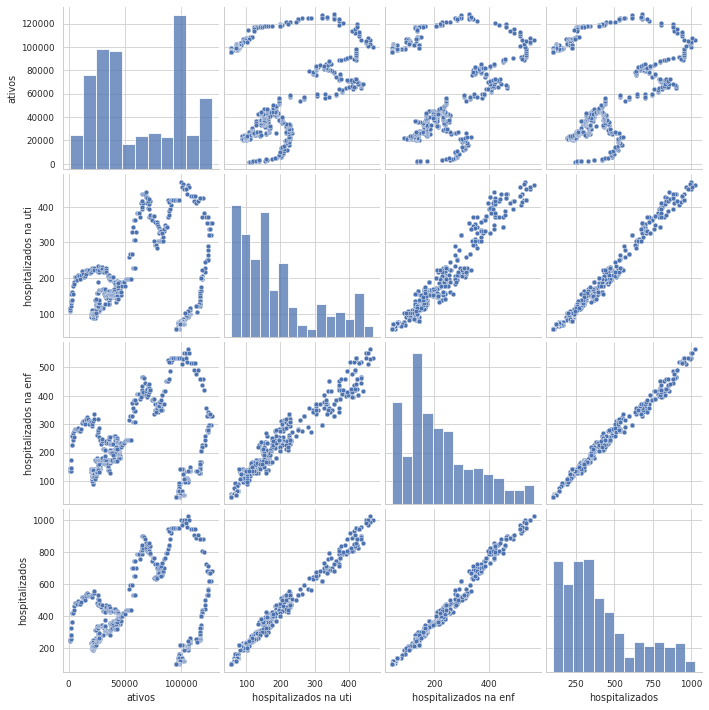

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper")
grafico = sns.pairplot(tabela1) #relações entre ativos e hospitalizados
grafico.savefig(caminho+"/relacoes_tabela1.png")

### Disponibilidade

In [ ]:
fig = make_subplots(rows=2, cols=1, 
                    start_cell="bottom-left",
                   subplot_titles=('UTIs disponiveis','Enfermarias disponíveis')
                   )
 

fig.add_trace(go.Scatter(
    x= (bancodados['Referencia']['qnt_enf'] - tabela1['hospitalizados na enf']).index,
    y= bancodados['Referencia']['qnt_uti']- tabela1['hospitalizados na uti'],
    name='UTIs disponíveis',
    showlegend=True,
    legendgroup= 'Paraíba',
    line=dict(color='Darkorange'),
), row=1, col=1)
 
fig.add_trace(go.Scatter(
    x= (bancodados['Referencia']['qnt_enf'] - tabela1['hospitalizados na enf']).index,
    y= bancodados['Referencia']['qnt_enf'] - tabela1['hospitalizados na enf'],
    name='Enfermarias disponíveis',
    showlegend=True,
    legendgroup= 'Paraíba',
    line=dict(color='CornflowerBlue'),
), row=2, col=1)
 
fig.update_layout(
    template="plotly_white",
    
    legend_orientation="h",
    legend=dict(x=0, y=-.1),
    width=700,
    height=700,
    font=dict(
        family="Times New Roman",
        size=13,
        color="DimGray"
    )
)
 
fig.update_yaxes(title_text="N.º Leitos (Unid)", row=1, col=1,showgrid=False, showline=True, showticklabels=True)
fig.update_yaxes(title_text="N.º Leitos (Unid)", row=2, col=1,showgrid=False, showline=True, showticklabels=True)

fig.update_xaxes(title_text="Data", row=1, col=1,showgrid=False, showline=True, showticklabels=True)
fig.update_xaxes(title_text="Data", row=2, col=1,showgrid=False, showline=True, showticklabels=True)
 


fig.show()
fig.write_image(caminho+'/leitos disponíveis.png') #leitos disponíveis na PARAÍBA

### Global

In [ ]:
tabela2 = pd.DataFrame() 

#taxas de casos graves em relação aos ativos
tabela2['Paraíba'] = (tabela1['hospitalizados na uti']/tabela1['ativos'])*100
tabela2['Brasil'] = (bancodados['PBBRMD']['brgraves'])/(bancodados['PBBRMD']['brativos'])*100
tabela2['Mundo'] = (bancodados['PBBRMD']['mdgraves'])/(bancodados['PBBRMD']['mdativos'])*100

tabela2.describe() #Count - qnt de elementos / mean - média /std - desvio padrão / min- mínimo / max - máximo

fig = go.Figure()

fig = make_subplots(rows=1, cols=2, 
                    start_cell="bottom-left",
                   subplot_titles=("Total",
                                   "Semana")
)
fig.add_trace(go.Scatter(
    x=tabela2['Paraíba'].index,
    y=tabela2['Paraíba'],
    name= 'Paraíba',
    showlegend=True,
    legendgroup= 'Paraíba',
    line=dict(color='DarkRed')
),row=1, col=1)


fig.add_trace(go.Scatter(
    x= tabela2['Brasil'].index,
    y= tabela2['Brasil'],
    name= 'Brasil',
    showlegend=True,
    legendgroup= 'Brasil',
    line=dict(color='SeaGreen')
),row=1, col=1)


fig.add_trace(go.Scatter(
    x= tabela2['Mundo'].index,
    y= tabela2['Mundo'],
    name= 'Mundo',
    showlegend=True,
    legendgroup= 'Mundo',
    line=dict(color='CornflowerBlue')
),row=1, col=1)



fig.add_trace(go.Scatter(
    x=tabela2['Paraíba'].loc[inicio_analise:final_analise].index,
    y=tabela2['Paraíba'].loc[inicio_analise:final_analise],
    name= 'Paraíba (Semana)',
    showlegend=False,
    legendgroup= 'Paraíba',
    line=dict(color='DarkRed')     # this sets its legend entry
),row=1, col=2)


fig.add_trace(go.Scatter(
    x= tabela2['Brasil'].loc[inicio_analise:final_analise].index,
    y= tabela2['Brasil'].loc[inicio_analise:final_analise],
    name= 'Brasil (Semana)',
    showlegend=False,
    legendgroup= 'Brasil',
    line=dict(color='SeaGreen')
),row=1, col=2)


fig.add_trace(go.Scatter(
    x= tabela2['Mundo'].loc[inicio_analise:final_analise].index,
    y= tabela2['Mundo'].loc[inicio_analise:final_analise],
    name= 'Mundo (Semana)',
    showlegend=False,
    legendgroup= 'Mundo',
    line=dict(color='CornflowerBlue')
),row=1, col=2)

fig.add_layout_image(
    dict(
        source='/content/drive/My Drive/Colab Notebooks/logo_nova.png',
        xref="paper", yref="paper",
        x=1, y=1,
        sizex=0.2, sizey=0.2,
        xanchor="right", yanchor="bottom"
    )
)

fig.update_layout(
    template="plotly_white",
    autosize=False,
    width=600,
    height=600,
    legend_title_text='Taxa de casos graves do(a):',
    legend_orientation="h",
    legend=dict(x=0, y=-.2),
    xaxis_title='Data',
    yaxis_title="Porcentagem",
    font=dict(
        family="Times New Roman",
        size=13,
        color="#7f7f7f"
    )
)



fig.update_yaxes(title_text="% Casos Graves", row=1, col=1)
fig.update_xaxes(title_text="Data", row=1, col=1)
fig.update_xaxes(title_text="Data", row=1, col=2)

fig.show() #casos graves em relação aos casos ativos
fig.write_image(caminho+"/br_pb_md.png")

In [ ]:
fig = make_subplots(rows=2, cols=1, 
                    start_cell="bottom-left",
                   subplot_titles=('UTIs adicionadas','Enfermarias adicionadas')
                   ) #calcula a adicao de leitos, não há um df para isso.

fig.add_trace(go.Scatter(
    x=bancodados['Referencia']['qnt_uti'].diff().cumsum().dropna().index,
    y=bancodados['Referencia']['qnt_uti'].diff().cumsum().dropna(), #calculou-se da seguinte forma:
                                                    #1º calculou a variação de leitos existentes
                                        #2º fez a soma acumulada dessa variação, formando a evolução da adição dos leitos
    line=dict(color='DarkOrange'),
    name= 'UTIs',
    showlegend=True,
    legendgroup= 'UTIs',
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=bancodados['Referencia']['qnt_enf'].diff().cumsum().dropna().index,
    y=bancodados['Referencia']['qnt_enf'].diff().cumsum().dropna(),
    line=dict(color='CornflowerBlue'),
    name= 'Enfermarias',
    showlegend=True,
    legendgroup= 'Enfermarias',
), row=2, col=1)


fig.update_layout(
    template="plotly_white",
    legend_orientation="h",
    legend=dict(x=0, y=-.1),
    width=800,
    height=600,
    font=dict(
        family="Times New Roman",
        size=13,
        color="DimGray"
    )
)

fig.update_yaxes(title_text="Leitos Adicionados" , nticks=10,  row=1, col=1,showgrid=False, showline=True, showticklabels=True)
fig.update_yaxes(title_text="Leitos Adicionados" , nticks=10, row=2, col=1,showgrid=False, showline=True, showticklabels=True)

fig.update_xaxes( nticks=20,  row=1, col=1,showgrid=False, showline=True, showticklabels=True)
fig.update_xaxes( nticks=20, row=2, col=1,showgrid=False, showline=True, showticklabels=True)


fig.show() #
fig.write_image(caminho+'/evolucao_adicao_leitos.png')

In [ ]:
evolucao_leitos_adicionados =pd.DataFrame(bancodados['Referencia'].diff().cumsum()[['qnt_uti','qnt_enf']])
evolucao_leitos_adicionados.iloc[-1] #até o momento as seguintes quantidades foram adicionadas

qnt_uti    97.0
qnt_enf   -16.0
Name: 2021-12-14 00:00:00, dtype: float64

In [ ]:
df_aux1 = leitos_por_hospital.loc[final_analise].dropna()
df_aux2 = leitos_por_hospital.loc[inicio_analise].dropna()
df_aux1.index = df_aux1['Unidade hospitalar']
df_aux2.index = df_aux2['Unidade hospitalar']
arte_enf_disp = pd.DataFrame(pd.concat([df_aux1['qnt_enf_unid_hosp'],df_aux2['qnt_enf_unid_hosp']],axis=1))
arte_enf_disp.columns = [inicio_analise,final_analise]
arte_enf_disp['VAR ENF'] = arte_enf_disp[final_analise]-arte_enf_disp[inicio_analise]

arte_enf_disp['Unidade hospitalar'] = arte_enf_disp.index

arte_uti_disp = pd.DataFrame(pd.concat([df_aux1['qnt_uti_unid_hosp'],df_aux2['qnt_uti_unid_hosp']],axis=1))
arte_uti_disp.columns = [inicio_analise,final_analise]
arte_uti_disp['VAR UTI'] = arte_uti_disp[final_analise]-arte_uti_disp[inicio_analise]
arte_uti_disp['Unidade hospitalar'] = arte_uti_disp.index

In [ ]:
data = px.data.gapminder()


fig = px.bar(arte_uti_disp.sort_values(by=final_analise).iloc[-10:], y='Unidade hospitalar', x=final_analise,orientation='h',
             hover_data=['VAR UTI'], color='VAR UTI',
             labels={final_analise:'Leitos disponíveis',
                     'VAR UTI': ' '}, height=400,
             color_continuous_scale=[(0, "darkorange"), (0.5, "yellow"), (1, "CornflowerBlue")],
             range_color=[-10,10])

fig.update_layout(
    template="plotly_white",
    
    legend_orientation="v",
    legend=dict(x=1, y=1),
    width=800,
    height=700,
    font=dict(
        family="Times New Roman",
        size=20,
        color="DimGray"
    )
)

fig.update_xaxes(title_text='UTIs disponíveis',showgrid=False, showline=True, showticklabels=True)
fig.update_yaxes(title_text='',showgrid=False, showline=True, showticklabels=True)


fig.show() #UTIS POR HOSP PARTE 1
fig.write_image(caminho+'/utis-hosp-parte1.png')

In [ ]:
data = px.data.gapminder()


fig = px.bar(arte_uti_disp.iloc[:math.ceil(len(arte_uti_disp)/2)], y='Unidade hospitalar', x=final_analise,orientation='h',
             hover_data=['VAR UTI'], color='VAR UTI',
             labels={final_analise:'Leitos disponíveis',
                     'VAR UTI': ' '}, height=400,
             color_continuous_scale=[(0, "darkorange"), (0.5, "yellow"), (1, "CornflowerBlue")],
             range_color=[-10,10])

fig.update_layout(
    template="plotly_white",
    title='UTIs disponíveis por hospital parte I',
    legend_orientation="v",
    legend=dict(x=1, y=1),
    width=800,
    height=800,
    font=dict(
        family="Times New Roman",
        size=16,
        color="DimGray"
    )
)

fig.update_yaxes(showgrid=False, showline=True, showticklabels=True)


fig.show() #UTIS POR HOSP PARTE 1
fig.write_image(caminho+'/utis-hosp-parte1.png')

In [ ]:
data = px.data.gapminder()


fig = px.bar(arte_uti_disp.iloc[math.ceil(len(arte_uti_disp)/2):], y='Unidade hospitalar', x=final_analise,orientation='h',
             hover_data=['VAR UTI'], color='VAR UTI',
             labels={final_analise:'Leitos disponíveis',
                     'VAR UTI': ' '}, height=400,
             color_continuous_scale=[(0, "darkorange"), (0.5, "yellow"), (1, "CornflowerBlue")],
             range_color=[-10,+10])

fig.update_layout(
    template="plotly_white",
    title='UTIs disponíveis por hospital parte II',
    legend_orientation="v",
    legend=dict(x=1, y=1),
    width=800,
    height=800,
    font=dict(
        family="Times New Roman",
        size=16,
        color="DimGray"
    )
)
fig.update_yaxes(showgrid=False, showline=True, showticklabels=True)
fig.show() #UTI DISPONÍVEIS POR HOSP PARTE 2 
#PERCEBA QUE o colormap está diferente da parte 1, anterior o verde máximo era 40 unidades.
#isso acontece por conta do plotly express ter pego o msm mas cortado. tive q dividir em 2 para a informação ficar mais legivel no instagram
#o correto é eu fazer u plotly go e discricionar todo o gráfico, porém o tempo está escasso, estou às 5:00 fazendo essas notas para organizar o código
fig.write_image(caminho+'/utis-hosp-parte2.png')

In [ ]:

fig = px.bar(arte_enf_disp.sort_values(by=final_analise).iloc[-10:], y='Unidade hospitalar', x=final_analise,orientation='h',
             hover_data=['VAR ENF'], color='VAR ENF',
             labels={final_analise:'Leitos disponíveis',
                     'VAR ENF': ' '}, height=400,
             color_continuous_scale=[(0, "darkorange"), (0.5, "yellow"), (1, "CornflowerBlue")],
             range_color=[-10,10])


fig.update_layout(
    template="plotly_white",
    title=' ',
    legend_orientation="v",
    legend=dict(x=1, y=1),
    width=800,
    height=700,
    font=dict(
        family="Times New Roman",
        size=20,
        color="DimGray"
    )
)

fig.update_xaxes(title_text='Enfermarias disponíveis',showgrid=False, showline=True, showticklabels=True)
fig.update_yaxes(title_text='',showgrid=False, showline=True, showticklabels=True)

fig.show() #ENFERMARIA DISP POR HOSP
fig.write_image(caminho+'/enfs-hosp-parte2.png')

In [ ]:


fig = px.bar(arte_enf_disp.iloc[:math.ceil(len(arte_enf_disp)/2)], y='Unidade hospitalar', x=final_analise,orientation='h',
             hover_data=['VAR ENF'], color='VAR ENF',
             labels={final_analise:'Leitos disponíveis',
                     'VAR ENF': ' '}, height=400,
             color_continuous_scale=[(0, "darkorange"), (0.5, "yellow"), (1, "CornflowerBlue")],
             range_color=[-10,10])


fig.update_layout(
    template="plotly_white",
    title='Enfermarias disponíveis por hospital parte I',
    legend_orientation="v",
    legend=dict(x=1, y=1),
    width=800,
    height=1000,
    font=dict(
        family="Times New Roman",
        size=20,
        color="DimGray"
    )
)

fig.update_yaxes(showgrid=False, showline=True, showticklabels=True)
fig.show() #ENFERMARIA DISP POR HOSP
fig.write_image(caminho+'/enfs-hosp-parte2.png')

In [ ]:


fig = px.bar(arte_enf_disp.iloc[math.ceil(len(arte_enf_disp)/2):], x='Unidade hospitalar', y=final_analise,
             hover_data=['VAR ENF'], color='VAR ENF',
             labels={final_analise:'Leitos disponíveis',
                     'VAR ENF': ' '}, height=400,
             color_continuous_scale=[(0, "darkorange"), (0.5, "yellow"), (1, "CornflowerBlue")],
             range_color=[-10,10])


fig.update_layout(
    template="plotly_white",
    title='Enfermarias disponíveis por hospital parte II',
    legend_orientation="v",
    legend=dict(x=1, y=1),
    width=800,
    height=800,
    font=dict(
        family="Times New Roman",
        size=16,
        color="DimGray"
    )
)
fig.update_yaxes(showgrid=False, showline=True, showticklabels=True)
fig.show() #ENFERMARIA DISP POR HOSP
fig.write_image(caminho+'/enfs-hosp-parte2.png')

# dados texto

gera um texto automático para o boletim no final do programa

In [ ]:

arte_secundaria_leitos_pb = pd.DataFrame([leitos_disponiveis.loc[inicio_analise], leitos_disponiveis.loc[final_analise]]).T


arte_secundaria_leitos_completa = arte_secundaria_leitos_pb.copy()


arte_secundaria_leitos_completa.index = ['UTI PB','ENF. PB']

arte_secundaria_leitos_completa.columns = [inicio_analise,final_analise]
arte_secundaria_leitos_completa['Variação Atual'] =  arte_secundaria_leitos_completa[final_analise]-arte_secundaria_leitos_completa[inicio_analise]
arte_secundaria_leitos_completa['Var. (%)'] = 100*(arte_secundaria_leitos_completa[final_analise]-arte_secundaria_leitos_completa[inicio_analise])/arte_secundaria_leitos_completa[inicio_analise]
arte_secundaria_leitos_completa['Variação Anterior'] = (leitos_disponiveis.loc[final_passada]-leitos_disponiveis.loc[inicio_passada]).to_list()

ordem_nova = ['Variação Anterior',inicio_analise,final_analise,'Variação Atual','Var. (%)']

arte_secundaria_leitos_completa = arte_secundaria_leitos_completa.reindex(ordem_nova, axis=1)
arte_secundaria_leitos_completa.iloc[:2] #há mais dados por conta da série que foi descontinuada, não exclui para preservar a histórica do código

,Variação Anterior,2021-12-08,2021-12-14,Variação Atual,Var. (%)
UTI PB,0.0,243.0,244.0,1.0,0.411523
ENF. PB,0.0,409.0,409.0,0.0,0.000000


In [ ]:
novos_leitos=pd.DataFrame()
novos_leitos['uti'] = bancodados['Referencia']['qnt_uti'].loc[inicio_analise:final_analise].diff()
novos_leitos['enf'] = bancodados['Referencia']['qnt_enf'].loc[inicio_analise:final_analise].diff()
novos_leitos.tail() #novos leitos adicionados na semana, o df de leitos adicionados foi criado após esse. não mesclei a origem da info por preguiça

,uti,enf
data,,
2021-12-10,0.0,0.0
2021-12-11,0.0,0.0
2021-12-12,1.0,0.0
2021-12-13,0.0,0.0
2021-12-14,0.0,0.0


In [ ]:
arte_principal_infectados = pd.DataFrame()
arte_principal_infectados['Variação anterior'] = (tabela1.loc[final_passada]-tabela1.loc[inicio_passada])
arte_principal_infectados[inicio_analise] = tabela1.loc[inicio_analise]
arte_principal_infectados[final_analise] = tabela1.loc[final_analise]
arte_principal_infectados['Variação atual'] = tabela1.loc[final_analise] - tabela1.loc[inicio_analise]
arte_principal_infectados['Var. atual (%)'] = 100*round(((arte_principal_infectados[final_analise] - arte_principal_infectados[inicio_analise])/arte_principal_infectados[inicio_analise]),2)
arte_principal_infectados #informações da tabela1, principais infos para arte post instagram

,Variação anterior,2021-12-08,2021-12-14,Variação atual,Var. atual (%)
ativos,-825.0,95449.0,95488.0,39.0,0.0
hospitalizados na uti,0.0,57.0,57.0,0.0,0.0
hospitalizados na enf,0.0,45.0,45.0,0.0,0.0
hospitalizados,0.0,102.0,103.0,1.0,1.0


In [ ]:
comparativo_d30
arte_d30 = pd.DataFrame()
arte_d30['Variação Anterior'] = comparativo_d30.loc[final_passada]-comparativo_d30.loc[inicio_passada]*100
arte_d30[inicio_analise] = comparativo_d30.loc[inicio_analise]*100
arte_d30[final_analise] = comparativo_d30.loc[final_analise]*100
arte_d30['Variação Atual'] = arte_d30[final_analise]-arte_d30[inicio_analise]
arte_d30 #comparativo 30 em relação  a 30 dias valores em %

,Variação Anterior,2021-12-08,2021-12-14,Variação Atual
ativos,-0.077371,-3.631997,-5.319283,-1.687286
hospitalizados na uti,14.786576,-19.232013,-20.198299,-0.966285
hospitalizados na enf,23.458390,-17.049280,-12.795529,4.253751
hospitalizados,18.768280,-18.518765,-16.932787,1.585978


In [ ]:
arte_graves = pd.DataFrame()
arte_graves['Variação Anterior'] = txagraveshosp.loc[final_passada]-txagraveshosp.loc[inicio_passada]
arte_graves[inicio_analise] = txagraveshosp.loc[inicio_analise]
arte_graves[final_analise] = txagraveshosp.loc[final_analise]
arte_graves['Variação Atual'] = arte_graves[final_analise]-arte_graves[inicio_analise]
arte_graves['Var. (%)'] = 100*(arte_graves[final_analise]-arte_graves[inicio_analise])/arte_graves[inicio_analise]
arte_graves

,Variação Anterior,2021-12-08,2021-12-14,Variação Atual,Var. (%)
Pacientes Graves Hospitalizados,0.0,55.882353,55.339806,-0.542547,-0.970874


In [ ]:
arte_pbr = pd.DataFrame()
arte_pbr['Variação Anterior'] = tabela2.loc[final_passada]-tabela2.loc[inicio_passada]
arte_pbr[inicio_analise] = tabela2.loc[inicio_analise]
arte_pbr[final_analise] = tabela2.loc[final_analise]
arte_pbr['Variação Atual'] = arte_pbr[final_analise]-arte_pbr[inicio_analise]
arte_pbr['Var. (%)'] = 100*(arte_pbr[final_analise]-arte_pbr[inicio_analise])/arte_pbr[inicio_analise]
arte_pbr

,Variação Anterior,2021-12-08,2021-12-14,Variação Atual,Var. (%)
Paraíba,0.000512,0.059718,0.059693,-0.000024,-0.040843
Brasil,-0.626720,4.855242,NaN,NaN,NaN
Mundo,-0.014037,0.411910,NaN,NaN,NaN


#DASHBOARD

In [ ]:
novos_nomes = []
for i in bancodados['Leitos Adultos'].columns:
  novos_nomes.append(i+' %ocupacao')
bancodados['Leitos Adultos'].columns = novos_nomes
saldo1.columns = ['variação ativos ', 'variação hospitalizados na uti', 'variação hospitalizados na enf',
       'variação hospitalizados']
tabela2.columns = ['Paraíba %graves/ativos', 'Brasil %graves/ativos', 'Mundo %graves/ativos']
novos_nomes = []
for i in bancodados['Leitos Disponíveis'].columns:
  novos_nomes.append(i+' disp.')
bancodados['Leitos Disponíveis'].columns = novos_nomes
novos_nomes = []
for i in comparativo_d30_sem_mme.columns:
  novos_nomes.append(i+' D30')
comparativo_d30_sem_mme.columns = novos_nomes
leitos_disponiveis.columns = ['UTI DISPONIVEIS','ENFERMARIAS DISPONIVEIS']
novos_nomes = []
for i in rep_leitos_por_mun_total.columns:
  novos_nomes.append('Representatividade total '+i)
rep_leitos_por_mun_total.columns = novos_nomes
dashboard = pd.DataFrame()

for i in bancodados:
  if i != 'leitos disponíveis por hospital':#para preservar o funcionamento do código, pois isso foi criado antes do leitos por hosp
    dashboard = pd.concat([dashboard,bancodados[i]],axis=1)
  else:
    pass
dashboard = pd.concat([dashboard,
                       tabela1,
                       saldo1,
                       txagraveshosp,
                       tabela2,
                       leitos_disponiveis,
                       comparativo_d30_sem_mme,
                       rep_leitos_por_mun_total],axis=1)

leitos_adicionados = bancodados['Referencia'][['qnt_uti','qnt_enf']].diff().cumsum().copy()
leitos_adicionados.columns = ['utis adc','enf adc']
dashboard = pd.concat([dashboard,leitos_adicionados],axis=1)

In [ ]:
dados = gc.open('DashBoardCOVID19').get_worksheet(0)
unid_hosp = gc.open('leitos_por_unidade_hosp').get_worksheet(0)

In [ ]:
set_with_dataframe(dados, dashboard, include_index=True) #inclui
set_with_dataframe(unid_hosp, leitos_por_hospital, include_index=True) #inclui

#Texto 

In [ ]:
arte_principal_infectados

,Variação anterior,2021-12-08,2021-12-14,Variação atual,Var. atual (%)
ativos,-825.0,95449.0,95488.0,39.0,0.0
hospitalizados na uti,0.0,57.0,57.0,0.0,0.0
hospitalizados na enf,0.0,45.0,45.0,0.0,0.0
hospitalizados,0.0,102.0,103.0,1.0,1.0


In [ ]:
print('Os dados analisados compreendem o período de',str(inicio_analise[-2:])+'/'+str(inicio_analise[-5:-3])+'/'+str(inicio_analise[:4]),
      'até',str(final_analise[-2:])+'/'+str(final_analise[-5:-3])+'/'+str(final_analise[:4]),
)

print('')

print('O número de casos ativos variou em',
      int(arte_principal_infectados.loc['ativos']['Variação atual']),
      '(variação de '+str(int(round(arte_principal_infectados.loc['ativos']['Var. atual (%)'],0)))+' por cento)',
      'infectados, alcançando a marca de',int(arte_principal_infectados.loc['ativos'][final_analise]),'infectados.',

      'Vale ressaltar que o número de casos ativos tem influência direta sobre o número de hospitalizados.'
)
print('')
print('Atualmente a Paraíba possui',int(arte_principal_infectados.loc['hospitalizados'][final_analise]),'hospitalizados',
      '(variação de '+str(int(round(arte_principal_infectados.loc['hospitalizados']['Variação atual'],0)))+' pacientes),',
      'sendo', int(arte_principal_infectados.loc['hospitalizados na uti'][final_analise]),'hospitalizados nas UTIs',
      '(variação de '+str(int(round(arte_principal_infectados.loc['hospitalizados na uti']['Variação atual'],0)))+' pacientes)','e',
      int(arte_principal_infectados.loc['hospitalizados na enf'][final_analise]),'hospitalizados nas enfermarias',
      '(variação de '+str(int(round(arte_principal_infectados.loc['hospitalizados na enf']['Variação atual'],0)))+' pacientes).',

      'Ao compararmos com semana passada, observamos que o número de hospitalizados variou em',
      arte_principal_infectados.loc['hospitalizados']['Variação atual']-arte_principal_infectados.loc['hospitalizados']['Variação anterior'], 'pacientes,',
      'enquanto que nas UTIs a variação foi de',arte_principal_infectados.loc['hospitalizados na uti']['Variação atual']-arte_principal_infectados.loc['hospitalizados na uti']['Variação anterior'],'pacientes',
      'e nas enfermarias de',arte_principal_infectados.loc['hospitalizados na enf']['Variação atual']-arte_principal_infectados.loc['hospitalizados na enf']['Variação anterior'],'pacientes.',

      'Quando consideramos 30 dias atrás temos as seguintes variações: hospitalizados',
      str(round(arte_d30.loc['hospitalizados'][final_analise],2))+' por cento |',
      'hospitalizados nas UTIs',
      str(round(arte_d30.loc['hospitalizados na uti'][final_analise],2))+' por cento |',
      'hospitalizados nas enfermarias',
      str(round(arte_d30.loc['hospitalizados na enf'][final_analise],2))+' por cento.',
      )

print('')
print('Até a data limite existiam',
      bancodados['Referencia'].loc[final_analise]['qnt_uti']+bancodados['Referencia'].loc[final_analise]['qnt_enf'], 'leitos na Paraíba, sendo',
      bancodados['Referencia'].loc[final_analise]['qnt_uti'],'UTIs e',bancodados['Referencia'].loc[final_analise]['qnt_enf'],'enfermarias.',
      'Foram adicionados',novos_leitos['uti'].loc[novos_leitos['uti'] !=0].sum(),'UTIs e',
      novos_leitos['enf'].loc[novos_leitos['enf'] !=0].sum(),'enfermarias.',
      'Encontram-se disponíveis na PB',arte_secundaria_leitos_completa.loc['UTI PB'][final_analise],'UTIs e',
      arte_secundaria_leitos_completa.loc['ENF. PB'][final_analise],'enfermarias.',
      'As UTIs disponíveis da PB variaram em',arte_secundaria_leitos_completa.loc['UTI PB']['Variação Atual'],'UTIs',
      '('+str(round((arte_secundaria_leitos_completa.loc['UTI PB']['Var. (%)']),2))+' por cento),',
      'frente a variação anterior de',arte_secundaria_leitos_completa.loc['UTI PB']['Variação Anterior'],'UTIs.',
      'Portanto, com uma variação relativa de',arte_secundaria_leitos_completa.loc['UTI PB']['Variação Atual']-arte_secundaria_leitos_completa.loc['UTI PB']['Variação Anterior'], 'UTIs.',
      'Já as Enfermarias disponíveis da PB variaram em',arte_secundaria_leitos_completa.loc['ENF. PB']['Variação Atual'],'enfermarias',
      '('+str(round((arte_secundaria_leitos_completa.loc['ENF. PB']['Var. (%)']),2))+' por cento),',
      'frente a variação anterior de',arte_secundaria_leitos_completa.loc['ENF. PB']['Variação Anterior'],'enfermarias.',
      'Portanto, com uma variação relativa de',arte_secundaria_leitos_completa.loc['ENF. PB']['Variação Atual']-arte_secundaria_leitos_completa.loc['ENF. PB']['Variação Anterior'], 'enfermarias.')


print(' ')

print('A Paraíba possui uma taxa de casos graves em relação aos ativos de',
      str(round(arte_pbr.loc['Paraíba'][final_analise],0))+' por cento',
      '(variação de '+str(round(arte_pbr.loc['Paraíba']['Variação Atual'],2))+' por cento),',
      'já o Mundo possui a taxa de casos graves em relação aos ativos de',
      str(round(arte_pbr.loc['Mundo'][final_analise],0))+' por cento',
      '(variação de '+str(round(arte_pbr.loc['Mundo']['Variação Atual'],2))+' por cento),',
      'e o Brasil de',
      str(round(arte_pbr.loc['Brasil'][final_analise],0))+' por cento',
      '(variação de '+str(round(arte_pbr.loc['Brasil']['Variação Atual'],2))+' por cento),',


      'Vale ressaltar que o Brasil não possui atualização no valor de casos graves hospitalizados desde o inicio de nossa coleta, estagnado em 8.318,',
      'enquanto que o número de casos ativos variou em',
      bancodados['PBBRMD'].iloc[-1]['brativos']-bancodados['PBBRMD'].iloc[0]['brativos'],
      'casos.',
      'Já a taxa de casos graves em relação aos hospitalizados é de',
      str(round(arte_graves.loc['Pacientes Graves Hospitalizados'][final_analise],0))+' por cento',
      '(variação de',str(round(arte_graves.loc['Pacientes Graves Hospitalizados']['Variação Atual'],0))+' por cento).')

print("")

Os dados analisados compreendem o período de 08/12/2021 até 14/12/2021

O número de casos ativos variou em 39 (variação de 0 por cento) infectados, alcançando a marca de 95488 infectados. Vale ressaltar que o número de casos ativos tem influência direta sobre o número de hospitalizados.

Atualmente a Paraíba possui 103 hospitalizados (variação de 1 pacientes), sendo 57 hospitalizados nas UTIs (variação de 0 pacientes) e 45 hospitalizados nas enfermarias (variação de 0 pacientes). Ao compararmos com semana passada, observamos que o número de hospitalizados variou em 1.0 pacientes, enquanto que nas UTIs a variação foi de 0.0 pacientes e nas enfermarias de 0.0 pacientes. Quando consideramos 30 dias atrás temos as seguintes variações: hospitalizados -16.93 por cento | hospitalizados nas UTIs -20.2 por cento | hospitalizados nas enfermarias -12.8 por cento.

Até a data limite existiam 755.0 leitos na Paraíba, sendo 301.0 UTIs e 454.0 enfermarias. Foram adicionados 1.0 UTIs e 0.0 enfermarias

In [ ]:
print(' ')
print('Descrição detalhada dos leitos disponíveis na Paraíba em',datetime.strptime(final_analise, '%Y-%m-%d').date().strftime('%d/%m/%y'))

n=0
for i in arte_uti_disp['Unidade hospitalar']:
  print(i,'possui', int(int(arte_enf_disp.fillna(0).iloc[n][final_analise])+int(arte_uti_disp.fillna(0).iloc[n][final_analise])),'leitos diponíveis, sendo: UTIs:',
        int(arte_uti_disp.fillna(0).iloc[n][final_analise]),'disponíveis (variação de',str(int(arte_uti_disp.fillna(0).iloc[n]['VAR UTI']))+' leitos) |',
        'Enfermarias:',int(arte_enf_disp.fillna(0).iloc[n][final_analise]),'disponíveis (variação de',str(int(arte_enf_disp.fillna(0).iloc[n]['VAR ENF']))+' leitos)')
  n+=1

#se existir nan vai dar erro, porém n influencia no restante do código

 
Descrição detalhada dos leitos disponíveis na Paraíba em 14/12/21
Hospital Municipal Pedro I possui 153 leitos diponíveis, sendo: UTIs: 53 disponíveis (variação de 0 leitos) | Enfermarias: 100 disponíveis (variação de 0 leitos)
Maternidade Frei Damiao - UNIDADE II possui 44 leitos diponíveis, sendo: UTIs: 3 disponíveis (variação de 0 leitos) | Enfermarias: 41 disponíveis (variação de 0 leitos)
Hospital Municipal Valentina possui 40 leitos diponíveis, sendo: UTIs: 10 disponíveis (variação de 0 leitos) | Enfermarias: 30 disponíveis (variação de 0 leitos)
Hospital Municipal Dr Severino Bezerra De Carvalho possui 33 leitos diponíveis, sendo: UTIs: 4 disponíveis (variação de 0 leitos) | Enfermarias: 29 disponíveis (variação de 0 leitos)
Hospital Metropolitano Dom Jose Maria Pires possui 41 leitos diponíveis, sendo: UTIs: 16 disponíveis (variação de 0 leitos) | Enfermarias: 25 disponíveis (variação de 0 leitos)
Hospital Wenceslau Lopes possui 34 leitos diponíveis, sendo: UTIs: 11 disponíve